# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 17            
model_seed = 7           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3277 | Test Loss 2.3140 | accs Train 0.0833 Test 0.1031


Epoch 100/3000: Train Loss 0.0080 | Test Loss 1.0606 | accs Train 1.0000 Test 0.6862


Epoch 200/3000: Train Loss 0.0031 | Test Loss 1.0921 | accs Train 1.0000 Test 0.6906


Epoch 300/3000: Train Loss 0.0019 | Test Loss 1.1119 | accs Train 1.0000 Test 0.6935


Epoch 400/3000: Train Loss 0.0013 | Test Loss 1.1266 | accs Train 1.0000 Test 0.6961


Epoch 500/3000: Train Loss 0.0010 | Test Loss 1.1384 | accs Train 1.0000 Test 0.6968


Epoch 600/3000: Train Loss 0.0008 | Test Loss 1.1480 | accs Train 1.0000 Test 0.6974


Epoch 700/3000: Train Loss 0.0007 | Test Loss 1.1562 | accs Train 1.0000 Test 0.6979


Epoch 800/3000: Train Loss 0.0006 | Test Loss 1.1632 | accs Train 1.0000 Test 0.6984


Epoch 900/3000: Train Loss 0.0005 | Test Loss 1.1694 | accs Train 1.0000 Test 0.6989


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.1748 | accs Train 1.0000 Test 0.6991


Epoch 1100/3000: Train Loss 0.0004 | Test Loss 1.1797 | accs Train 1.0000 Test 0.6994


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.1841 | accs Train 1.0000 Test 0.6999


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.1880 | accs Train 1.0000 Test 0.7000


Epoch 1400/3000: Train Loss 0.0003 | Test Loss 1.1916 | accs Train 1.0000 Test 0.7002


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.1949 | accs Train 1.0000 Test 0.7000


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.1980 | accs Train 1.0000 Test 0.7002


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.2008 | accs Train 1.0000 Test 0.7005


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.2034 | accs Train 1.0000 Test 0.7009


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.2058 | accs Train 1.0000 Test 0.7010


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.2080 | accs Train 1.0000 Test 0.7010


Epoch 2100/3000: Train Loss 0.0002 | Test Loss 1.2100 | accs Train 1.0000 Test 0.7011


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.2119 | accs Train 1.0000 Test 0.7011


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.2137 | accs Train 1.0000 Test 0.7014


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.2153 | accs Train 1.0000 Test 0.7018


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.2169 | accs Train 1.0000 Test 0.7020


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.2183 | accs Train 1.0000 Test 0.7019


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.2196 | accs Train 1.0000 Test 0.7022


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.2208 | accs Train 1.0000 Test 0.7022


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.2219 | accs Train 1.0000 Test 0.7020


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.2230 | accs Train 1.0000 Test 0.7019
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3220 | Test Loss 2.3140 | accs Train 0.0917 Test 0.1028


Epoch 100/3000: Train Loss 0.1464 | Test Loss 0.4173 | accs Train 0.9733 Test 0.8775


Epoch 200/3000: Train Loss 0.0286 | Test Loss 0.4526 | accs Train 1.0000 Test 0.8793


Epoch 300/3000: Train Loss 0.0124 | Test Loss 0.4868 | accs Train 1.0000 Test 0.8806


Epoch 400/3000: Train Loss 0.0074 | Test Loss 0.5108 | accs Train 1.0000 Test 0.8811


Epoch 500/3000: Train Loss 0.0052 | Test Loss 0.5289 | accs Train 1.0000 Test 0.8810


Epoch 600/3000: Train Loss 0.0039 | Test Loss 0.5433 | accs Train 1.0000 Test 0.8807


Epoch 700/3000: Train Loss 0.0031 | Test Loss 0.5551 | accs Train 1.0000 Test 0.8805


Epoch 800/3000: Train Loss 0.0026 | Test Loss 0.5651 | accs Train 1.0000 Test 0.8802


Epoch 900/3000: Train Loss 0.0022 | Test Loss 0.5736 | accs Train 1.0000 Test 0.8793


Epoch 1000/3000: Train Loss 0.0019 | Test Loss 0.5811 | accs Train 1.0000 Test 0.8788


Epoch 1100/3000: Train Loss 0.0017 | Test Loss 0.5877 | accs Train 1.0000 Test 0.8788


Epoch 1200/3000: Train Loss 0.0015 | Test Loss 0.5937 | accs Train 1.0000 Test 0.8788


Epoch 1300/3000: Train Loss 0.0014 | Test Loss 0.5990 | accs Train 1.0000 Test 0.8786


Epoch 1400/3000: Train Loss 0.0013 | Test Loss 0.6038 | accs Train 1.0000 Test 0.8786


Epoch 1500/3000: Train Loss 0.0012 | Test Loss 0.6082 | accs Train 1.0000 Test 0.8787


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.6123 | accs Train 1.0000 Test 0.8787


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.6160 | accs Train 1.0000 Test 0.8786


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6195 | accs Train 1.0000 Test 0.8786


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.6227 | accs Train 1.0000 Test 0.8784


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6256 | accs Train 1.0000 Test 0.8784


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6284 | accs Train 1.0000 Test 0.8783


Epoch 2200/3000: Train Loss 0.0008 | Test Loss 0.6310 | accs Train 1.0000 Test 0.8781


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.6334 | accs Train 1.0000 Test 0.8781


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.6357 | accs Train 1.0000 Test 0.8782


Epoch 2500/3000: Train Loss 0.0007 | Test Loss 0.6378 | accs Train 1.0000 Test 0.8781


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.6398 | accs Train 1.0000 Test 0.8782


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6417 | accs Train 1.0000 Test 0.8785


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.6435 | accs Train 1.0000 Test 0.8785


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.6451 | accs Train 1.0000 Test 0.8785


Epoch 3000/3000: Train Loss 0.0006 | Test Loss 0.6467 | accs Train 1.0000 Test 0.8783
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3189 | Test Loss 2.3139 | accs Train 0.0975 Test 0.1029


Epoch 100/3000: Train Loss 0.2719 | Test Loss 0.3681 | accs Train 0.9195 Test 0.8889


Epoch 200/3000: Train Loss 0.1328 | Test Loss 0.3231 | accs Train 0.9735 Test 0.9021


Epoch 300/3000: Train Loss 0.0695 | Test Loss 0.3294 | accs Train 0.9900 Test 0.9049


Epoch 400/3000: Train Loss 0.0378 | Test Loss 0.3464 | accs Train 0.9975 Test 0.9042


Epoch 500/3000: Train Loss 0.0224 | Test Loss 0.3636 | accs Train 0.9990 Test 0.9046


Epoch 600/3000: Train Loss 0.0149 | Test Loss 0.3780 | accs Train 1.0000 Test 0.9051


Epoch 700/3000: Train Loss 0.0108 | Test Loss 0.3902 | accs Train 1.0000 Test 0.9056


Epoch 800/3000: Train Loss 0.0083 | Test Loss 0.4006 | accs Train 1.0000 Test 0.9061


Epoch 900/3000: Train Loss 0.0066 | Test Loss 0.4095 | accs Train 1.0000 Test 0.9062


Epoch 1000/3000: Train Loss 0.0055 | Test Loss 0.4173 | accs Train 1.0000 Test 0.9059


Epoch 1100/3000: Train Loss 0.0046 | Test Loss 0.4241 | accs Train 1.0000 Test 0.9063


Epoch 1200/3000: Train Loss 0.0040 | Test Loss 0.4301 | accs Train 1.0000 Test 0.9063


Epoch 1300/3000: Train Loss 0.0035 | Test Loss 0.4355 | accs Train 1.0000 Test 0.9063


Epoch 1400/3000: Train Loss 0.0031 | Test Loss 0.4404 | accs Train 1.0000 Test 0.9062


Epoch 1500/3000: Train Loss 0.0028 | Test Loss 0.4448 | accs Train 1.0000 Test 0.9061


Epoch 1600/3000: Train Loss 0.0026 | Test Loss 0.4488 | accs Train 1.0000 Test 0.9066


Epoch 1700/3000: Train Loss 0.0023 | Test Loss 0.4525 | accs Train 1.0000 Test 0.9069


Epoch 1800/3000: Train Loss 0.0022 | Test Loss 0.4559 | accs Train 1.0000 Test 0.9068


Epoch 1900/3000: Train Loss 0.0020 | Test Loss 0.4591 | accs Train 1.0000 Test 0.9070


Epoch 2000/3000: Train Loss 0.0019 | Test Loss 0.4619 | accs Train 1.0000 Test 0.9071


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.4646 | accs Train 1.0000 Test 0.9070


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.4671 | accs Train 1.0000 Test 0.9071


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4695 | accs Train 1.0000 Test 0.9070


Epoch 2400/3000: Train Loss 0.0015 | Test Loss 0.4716 | accs Train 1.0000 Test 0.9070


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.4737 | accs Train 1.0000 Test 0.9071


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.4756 | accs Train 1.0000 Test 0.9071


Epoch 2700/3000: Train Loss 0.0013 | Test Loss 0.4774 | accs Train 1.0000 Test 0.9074


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.4791 | accs Train 1.0000 Test 0.9076


Epoch 2900/3000: Train Loss 0.0012 | Test Loss 0.4808 | accs Train 1.0000 Test 0.9077


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.4823 | accs Train 1.0000 Test 0.9078
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3158 | Test Loss 2.3139 | accs Train 0.1028 Test 0.1029


Epoch 100/3000: Train Loss 0.3316 | Test Loss 0.3466 | accs Train 0.9003 Test 0.9010


Epoch 200/3000: Train Loss 0.2193 | Test Loss 0.2748 | accs Train 0.9390 Test 0.9206


Epoch 300/3000: Train Loss 0.1603 | Test Loss 0.2465 | accs Train 0.9582 Test 0.9284


Epoch 400/3000: Train Loss 0.1186 | Test Loss 0.2304 | accs Train 0.9725 Test 0.9334


Epoch 500/3000: Train Loss 0.0866 | Test Loss 0.2203 | accs Train 0.9832 Test 0.9351


Epoch 600/3000: Train Loss 0.0625 | Test Loss 0.2146 | accs Train 0.9898 Test 0.9378


Epoch 700/3000: Train Loss 0.0451 | Test Loss 0.2120 | accs Train 0.9942 Test 0.9389


Epoch 800/3000: Train Loss 0.0330 | Test Loss 0.2117 | accs Train 0.9963 Test 0.9391


Epoch 900/3000: Train Loss 0.0247 | Test Loss 0.2127 | accs Train 0.9983 Test 0.9400


Epoch 1000/3000: Train Loss 0.0190 | Test Loss 0.2142 | accs Train 0.9992 Test 0.9408


Epoch 1100/3000: Train Loss 0.0150 | Test Loss 0.2160 | accs Train 0.9997 Test 0.9415


Epoch 1200/3000: Train Loss 0.0121 | Test Loss 0.2181 | accs Train 0.9998 Test 0.9419


Epoch 1300/3000: Train Loss 0.0101 | Test Loss 0.2201 | accs Train 0.9998 Test 0.9422


Epoch 1400/3000: Train Loss 0.0086 | Test Loss 0.2221 | accs Train 1.0000 Test 0.9427


Epoch 1500/3000: Train Loss 0.0074 | Test Loss 0.2240 | accs Train 1.0000 Test 0.9430


Epoch 1600/3000: Train Loss 0.0065 | Test Loss 0.2258 | accs Train 1.0000 Test 0.9436


Epoch 1700/3000: Train Loss 0.0057 | Test Loss 0.2275 | accs Train 1.0000 Test 0.9436


Epoch 1800/3000: Train Loss 0.0051 | Test Loss 0.2291 | accs Train 1.0000 Test 0.9436


Epoch 1900/3000: Train Loss 0.0046 | Test Loss 0.2305 | accs Train 1.0000 Test 0.9437


Epoch 2000/3000: Train Loss 0.0042 | Test Loss 0.2319 | accs Train 1.0000 Test 0.9436


Epoch 2100/3000: Train Loss 0.0039 | Test Loss 0.2331 | accs Train 1.0000 Test 0.9438


Epoch 2200/3000: Train Loss 0.0036 | Test Loss 0.2343 | accs Train 1.0000 Test 0.9437


Epoch 2300/3000: Train Loss 0.0033 | Test Loss 0.2354 | accs Train 1.0000 Test 0.9438


Epoch 2400/3000: Train Loss 0.0031 | Test Loss 0.2365 | accs Train 1.0000 Test 0.9439


Epoch 2500/3000: Train Loss 0.0029 | Test Loss 0.2374 | accs Train 1.0000 Test 0.9439


Epoch 2600/3000: Train Loss 0.0027 | Test Loss 0.2384 | accs Train 1.0000 Test 0.9440


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2392 | accs Train 1.0000 Test 0.9441


Epoch 2800/3000: Train Loss 0.0024 | Test Loss 0.2400 | accs Train 1.0000 Test 0.9442


Epoch 2900/3000: Train Loss 0.0023 | Test Loss 0.2408 | accs Train 1.0000 Test 0.9444


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2415 | accs Train 1.0000 Test 0.9444
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3143 | Test Loss 2.3139 | accs Train 0.1037 Test 0.1029


Epoch 100/3000: Train Loss 0.3486 | Test Loss 0.3382 | accs Train 0.8959 Test 0.9033


Epoch 200/3000: Train Loss 0.2603 | Test Loss 0.2639 | accs Train 0.9235 Test 0.9232


Epoch 300/3000: Train Loss 0.2141 | Test Loss 0.2279 | accs Train 0.9404 Test 0.9344


Epoch 400/3000: Train Loss 0.1797 | Test Loss 0.2017 | accs Train 0.9497 Test 0.9407


Epoch 500/3000: Train Loss 0.1523 | Test Loss 0.1808 | accs Train 0.9581 Test 0.9467


Epoch 600/3000: Train Loss 0.1297 | Test Loss 0.1644 | accs Train 0.9646 Test 0.9516


Epoch 700/3000: Train Loss 0.1111 | Test Loss 0.1514 | accs Train 0.9700 Test 0.9555


Epoch 800/3000: Train Loss 0.0953 | Test Loss 0.1411 | accs Train 0.9743 Test 0.9589


Epoch 900/3000: Train Loss 0.0818 | Test Loss 0.1329 | accs Train 0.9792 Test 0.9608


Epoch 1000/3000: Train Loss 0.0703 | Test Loss 0.1267 | accs Train 0.9833 Test 0.9627


Epoch 1100/3000: Train Loss 0.0606 | Test Loss 0.1220 | accs Train 0.9859 Test 0.9635


Epoch 1200/3000: Train Loss 0.0523 | Test Loss 0.1184 | accs Train 0.9885 Test 0.9646


Epoch 1300/3000: Train Loss 0.0452 | Test Loss 0.1158 | accs Train 0.9905 Test 0.9658


Epoch 1400/3000: Train Loss 0.0391 | Test Loss 0.1139 | accs Train 0.9926 Test 0.9663


Epoch 1500/3000: Train Loss 0.0338 | Test Loss 0.1126 | accs Train 0.9944 Test 0.9675


Epoch 1600/3000: Train Loss 0.0294 | Test Loss 0.1117 | accs Train 0.9953 Test 0.9679


Epoch 1700/3000: Train Loss 0.0257 | Test Loss 0.1111 | accs Train 0.9963 Test 0.9682


Epoch 1800/3000: Train Loss 0.0225 | Test Loss 0.1108 | accs Train 0.9970 Test 0.9682


Epoch 1900/3000: Train Loss 0.0198 | Test Loss 0.1107 | accs Train 0.9977 Test 0.9687


Epoch 2000/3000: Train Loss 0.0175 | Test Loss 0.1107 | accs Train 0.9982 Test 0.9694


Epoch 2100/3000: Train Loss 0.0155 | Test Loss 0.1109 | accs Train 0.9989 Test 0.9692


Epoch 2200/3000: Train Loss 0.0139 | Test Loss 0.1112 | accs Train 0.9992 Test 0.9695


Epoch 2300/3000: Train Loss 0.0125 | Test Loss 0.1115 | accs Train 0.9995 Test 0.9700


Epoch 2400/3000: Train Loss 0.0113 | Test Loss 0.1119 | accs Train 0.9996 Test 0.9700


Epoch 2500/3000: Train Loss 0.0102 | Test Loss 0.1124 | accs Train 0.9997 Test 0.9702


Epoch 2600/3000: Train Loss 0.0093 | Test Loss 0.1128 | accs Train 0.9998 Test 0.9699


Epoch 2700/3000: Train Loss 0.0085 | Test Loss 0.1133 | accs Train 0.9998 Test 0.9697


Epoch 2800/3000: Train Loss 0.0078 | Test Loss 0.1138 | accs Train 0.9998 Test 0.9697


Epoch 2900/3000: Train Loss 0.0072 | Test Loss 0.1143 | accs Train 0.9998 Test 0.9699


Epoch 3000/3000: Train Loss 0.0067 | Test Loss 0.1148 | accs Train 0.9999 Test 0.9701
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3141 | Test Loss 2.3139 | accs Train 0.1041 Test 0.1029


Epoch 100/3000: Train Loss 0.3540 | Test Loss 0.3379 | accs Train 0.8964 Test 0.9024


Epoch 200/3000: Train Loss 0.2703 | Test Loss 0.2615 | accs Train 0.9219 Test 0.9232


Epoch 300/3000: Train Loss 0.2278 | Test Loss 0.2239 | accs Train 0.9347 Test 0.9351


Epoch 400/3000: Train Loss 0.1963 | Test Loss 0.1956 | accs Train 0.9441 Test 0.9437


Epoch 500/3000: Train Loss 0.1708 | Test Loss 0.1725 | accs Train 0.9521 Test 0.9503


Epoch 600/3000: Train Loss 0.1501 | Test Loss 0.1542 | accs Train 0.9580 Test 0.9551


Epoch 700/3000: Train Loss 0.1333 | Test Loss 0.1396 | accs Train 0.9629 Test 0.9590


Epoch 800/3000: Train Loss 0.1193 | Test Loss 0.1279 | accs Train 0.9671 Test 0.9617


Epoch 900/3000: Train Loss 0.1073 | Test Loss 0.1184 | accs Train 0.9700 Test 0.9646


Epoch 1000/3000: Train Loss 0.0971 | Test Loss 0.1105 | accs Train 0.9729 Test 0.9670


Epoch 1100/3000: Train Loss 0.0882 | Test Loss 0.1040 | accs Train 0.9753 Test 0.9686


Epoch 1200/3000: Train Loss 0.0804 | Test Loss 0.0986 | accs Train 0.9776 Test 0.9701


Epoch 1300/3000: Train Loss 0.0735 | Test Loss 0.0940 | accs Train 0.9801 Test 0.9718


Epoch 1400/3000: Train Loss 0.0675 | Test Loss 0.0900 | accs Train 0.9817 Test 0.9726


Epoch 1500/3000: Train Loss 0.0620 | Test Loss 0.0867 | accs Train 0.9835 Test 0.9737


Epoch 1600/3000: Train Loss 0.0572 | Test Loss 0.0837 | accs Train 0.9854 Test 0.9747


Epoch 1700/3000: Train Loss 0.0529 | Test Loss 0.0812 | accs Train 0.9868 Test 0.9753


Epoch 1800/3000: Train Loss 0.0489 | Test Loss 0.0790 | accs Train 0.9877 Test 0.9760


Epoch 1900/3000: Train Loss 0.0454 | Test Loss 0.0772 | accs Train 0.9886 Test 0.9765


Epoch 2000/3000: Train Loss 0.0421 | Test Loss 0.0756 | accs Train 0.9894 Test 0.9769


Epoch 2100/3000: Train Loss 0.0392 | Test Loss 0.0742 | accs Train 0.9904 Test 0.9776


Epoch 2200/3000: Train Loss 0.0365 | Test Loss 0.0729 | accs Train 0.9913 Test 0.9772


Epoch 2300/3000: Train Loss 0.0340 | Test Loss 0.0718 | accs Train 0.9920 Test 0.9775


Epoch 2400/3000: Train Loss 0.0317 | Test Loss 0.0709 | accs Train 0.9928 Test 0.9781


Epoch 2500/3000: Train Loss 0.0296 | Test Loss 0.0701 | accs Train 0.9935 Test 0.9784


Epoch 2600/3000: Train Loss 0.0277 | Test Loss 0.0694 | accs Train 0.9941 Test 0.9781


Epoch 2700/3000: Train Loss 0.0259 | Test Loss 0.0688 | accs Train 0.9946 Test 0.9780


Epoch 2800/3000: Train Loss 0.0243 | Test Loss 0.0683 | accs Train 0.9951 Test 0.9782


Epoch 2900/3000: Train Loss 0.0228 | Test Loss 0.0679 | accs Train 0.9954 Test 0.9783


Epoch 3000/3000: Train Loss 0.0214 | Test Loss 0.0676 | accs Train 0.9959 Test 0.9787
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.2230 | accs: 0.7019
 540 samples | Test Loss: 0.6467 | accs: 0.8783
1940 samples | Test Loss: 0.4823 | accs: 0.9078
5940 samples | Test Loss: 0.2415 | accs: 0.9444
19940 samples | Test Loss: 0.1148 | accs: 0.9701
59940 samples | Test Loss: 0.0676 | accs: 0.9787

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0004 | accs: 1.0000
 Model 1940 | Train Loss: 0.0008 | accs: 1.0000
 Model 5940 | Train Loss: 0.0012 | accs: 1.0000
 Model 19940 | Train Loss: 0.0058 | accs: 1.0000
 Model 59940 | Train Loss: 0.0147 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.2608 | accs: 0.7017
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0011 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0060 | accs: 1.0000
 Model 59940 | Trai

 Model 5940 | Train Loss: 0.2726 | accs: 0.9444
 Model 19940 | Train Loss: 0.0888 | accs: 0.9771
 Model 59940 | Train Loss: 0.0214 | accs: 0.9959


### Model + Data Specific Verification

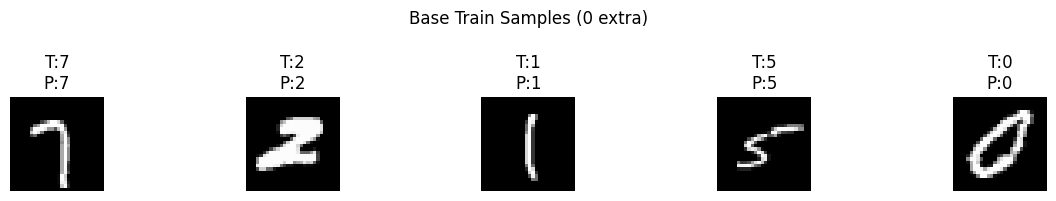

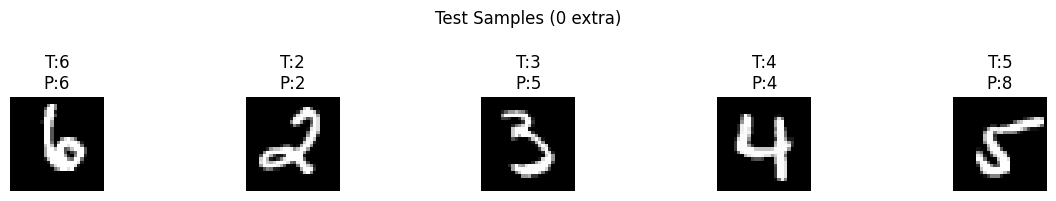

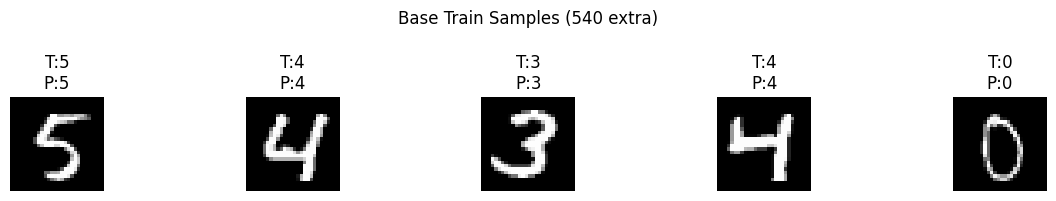

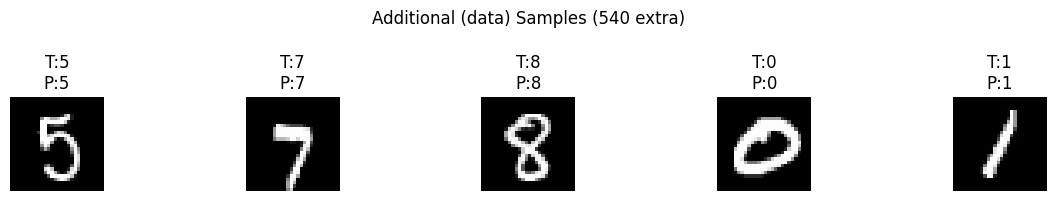

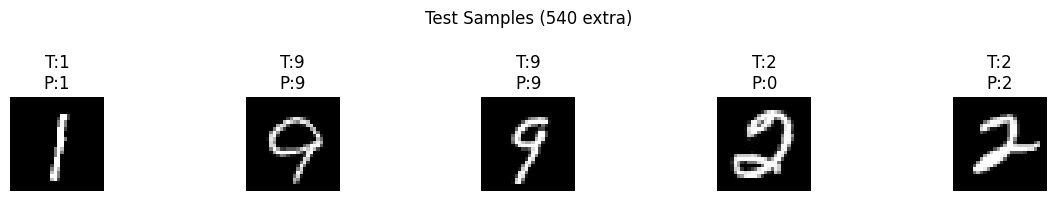

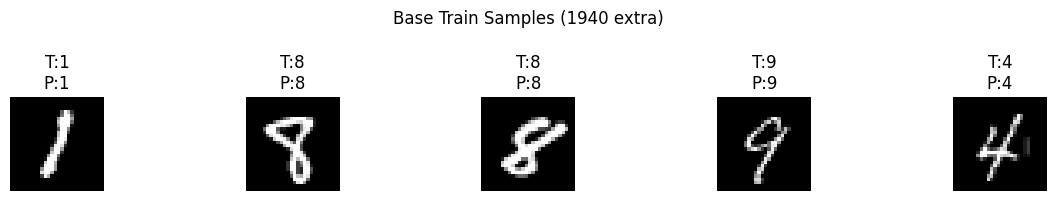

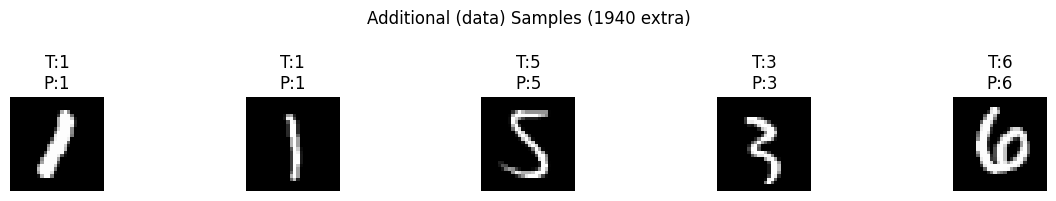

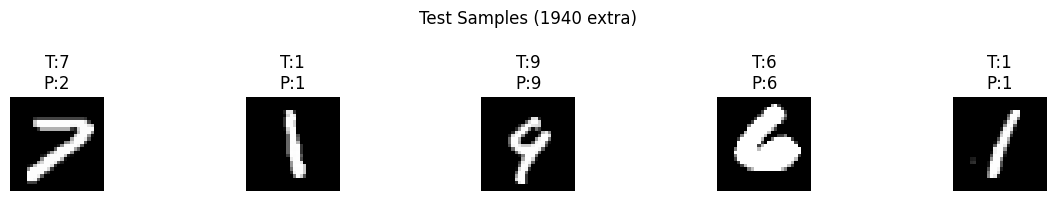

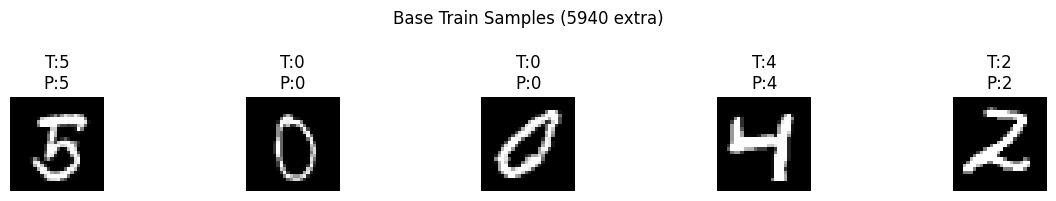

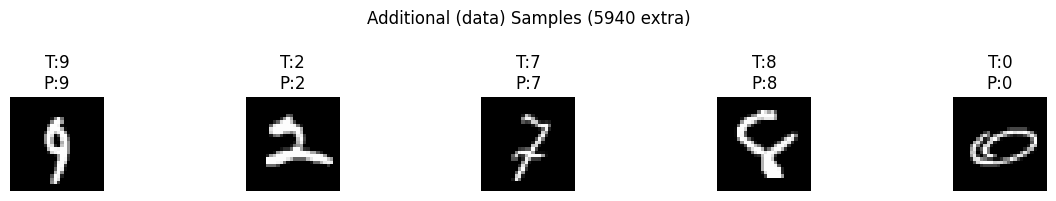

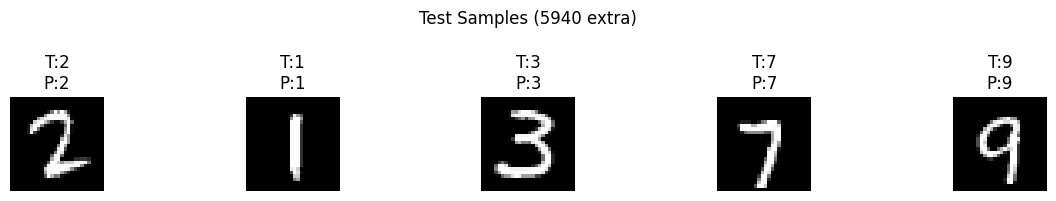

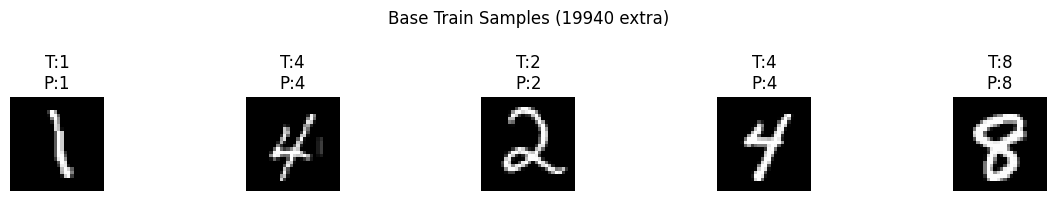

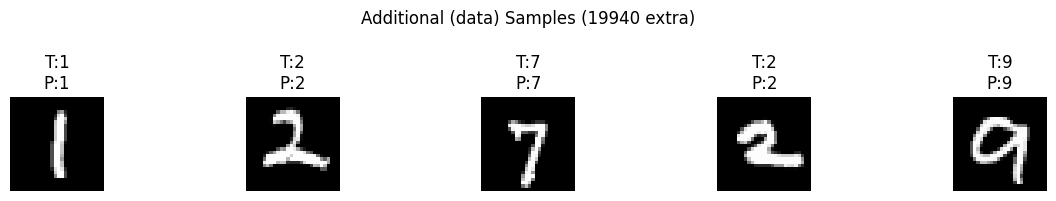

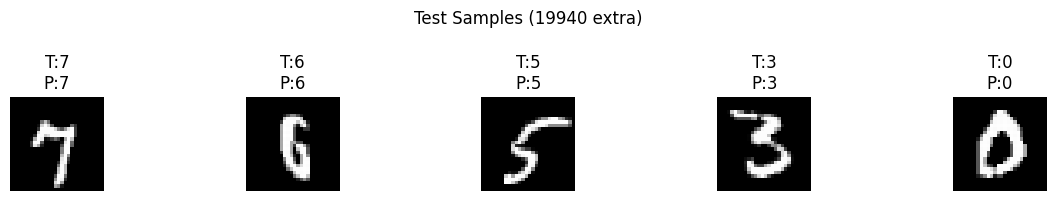

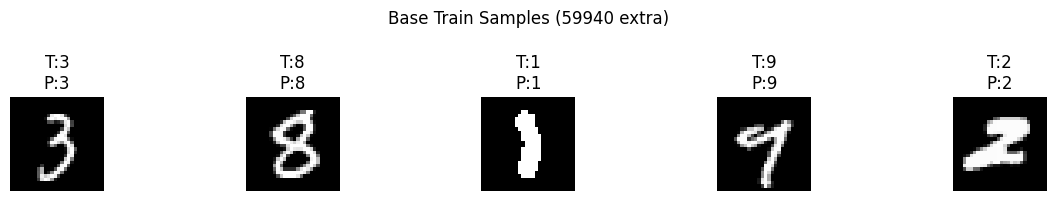

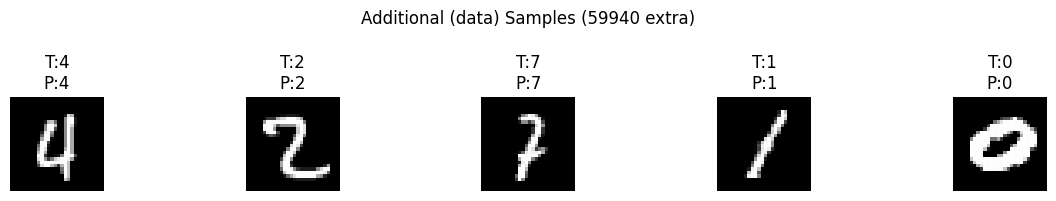

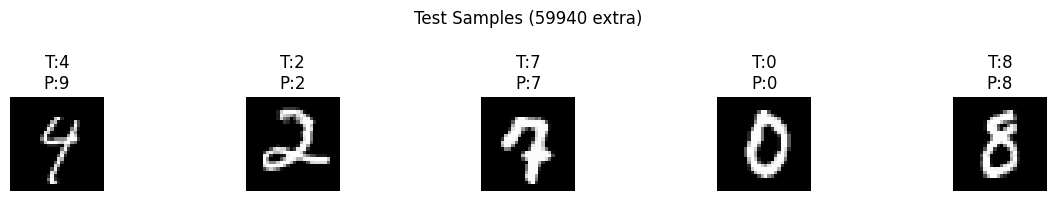

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
